In [1]:
import numpy as np
import math
import skimage.io
import skimage.transform
import skimage.color
import skimage

from PIL import Image

def process(sample, flip_x=0.15, shift = 0.3, scale = 0.4, rotate = 0.5, noise = 0.6):
        rand = np.random.rand()
        image, annots = sample['img'], sample['annot']
        if rand < flip_x:
            print("flip_x")
#             print(image)
            image = image[:,::-1,:]#横向翻转，20%的概率
#             print(image)
            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            x2 = annots[:, 2].copy()
            
            x_tmp = x1.copy()

            annots[:, 0] = cols - x2
            annots[:, 2] = cols - x_tmp

            sample = {'img': image, 'annot': annots}
            
        elif rand < shift:#平移
            print("shift")
            delta_x = 50
            delta_y = 50
            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            y1 = annots[:, 1].copy()
            x2 = annots[:, 2].copy()
            y2 = annots[:, 3].copy()
            
           
            
            emptyImage = image.copy()
            if np.random.rand() < 0.5: #右移
                annots[:,0] = x1 + delta_x
                annots[:,2] = x2 + delta_x
                for i in range(rows):

                    if i>=delta_x:
                        emptyImage[i,:]=image[i-delta_x,:]
                    else:
                        emptyImage[i,:]=(0,0,0)
            else : #左移
                annots[:,0] = x1 - delta_x
                annots[:,2] = x2 - delta_x
                for i in range(rows):
                    if i< rows-delta_x:
                        emptyImage[i,:]=image[i+delta_x,:]
                    else:
                        emptyImage[i,:]=(0,0,0)
            if np.random.rand() < 0.5: #下移
                annots[:,1] = y1 + delta_y
                annots[:,3] = y2 + delta_y
                for j in range(cols):
                    if j>=delta_y:
                        print("shifting down")
                        emptyImage[:,j,:]=image[:,j-delta_y,:]
                    else:
                        emptyImage[:,j,:]=(0,0,0)
            else: #上移
                annots[:,1] = y1 - delta_y
                annots[:,3] = y2 - delta_y
                for j in range(cols):
                    if j<cols - delta_y:
                        emptyImage[:,j]=image[:,j+delta_y]
                        print("shifting up")
                    else:
                        emptyImage[:,j]=(0,0,0)
            sample = {'img': emptyImage, 'annot': annots}
            
        elif rand < scale:
            print("scale")
            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            y1 = annots[:, 1].copy()
            x2 = annots[:, 2].copy()
            y2 = annots[:, 3].copy()
            
            emptyImage = image.copy()
            rand_tmp = np.random.rand()
            if rand_tmp < 0.5:#放大
                degree = 0.9
            else:
                degree = 1.1
            annots[:, 0] = (x1 * [degree,]).astype(np.uint8)
            annots[:, 1] = (y1 * [degree,]).astype(np.uint8)
            annots[:, 2] = (x2 * [degree,]).astype(np.uint8)
            annots[:, 3] = (y2 * [degree,]).astype(np.uint8)
            
            for j in range(cols):
                for i in range(rows):
                    if j/degree > 0 and j/degree < cols and i/degree > 0 and i/degree < rows:
                        emptyImage[i,j] = image[int(i/degree),int(j/degree)]
                    else:
                        emptyImage[i,j] = (0,0,0)
                    
                
            sample = {'img': emptyImage, 'annot': annots}
        elif rand < rotate:##TODO 
            print("rotate")
            rand_tmp = np.random.rand()
            if rand_tmp < 0.25:
                angle = 15
            elif rand_tmp < 0.5:
                angle = -15
            elif rand_tmp < 0.75:
                angle = 30
            else:
                angle = -30
            h, w, channels = image.shape
            x1 = annots[:, 0].copy()
            y1 = annots[:, 1].copy()
            x2 = annots[:, 2].copy()
            y2 = annots[:, 3].copy()
            
            anglePi = angle * math.pi / 180.0
            cosA = math.cos(anglePi)
            sinA = math.sin(anglePi)
            X1 = math.ceil(abs(0.5 * h * cosA + 0.5 * w * sinA))
            X2 = math.ceil(abs(0.5 * h * cosA - 0.5 * w * sinA))
            Y1 = math.ceil(abs(-0.5 * h * sinA + 0.5 * w * cosA))
            Y2 = math.ceil(abs(-0.5 * h * sinA - 0.5 * w * cosA))
            hh = int(2 * max(Y1, Y2))
            ww = int(2 * max(X1, X2))
            
#             X1 = math.ceil(abs( x1 * cosA +  y1 * sinA))
#             X2 = math.ceil(abs(x2 * cosA + y2 * sinA))
#             Y1 = math.ceil(abs(-1 * x1 * sinA + y1 * cosA))
#             Y2 = math.ceil(abs(-1 * x2 * sinA + y2 * cosA))
            X1 = abs(x1 * cosA +  y1 * sinA)
            X2 = abs(x2 * cosA +  y2 * sinA)
            Y1 = abs(-1 * x1 * sinA + y1 * cosA)
            Y2 = abs(-1 * x2 * sinA + y2 * cosA)
            for i in range(annots.shape[0]):
                annots[i,0] = int(min(X1[i], X2[i]))
                annots[i,1] = int(min(Y1[i], Y2[i]))
                annots[i,2] = int(max(X1[i], X2[i]))
                annots[i,3] = int(max(Y1[i], Y2[i]))
            
            emptyImage = np.zeros((hh, ww, channels), np.uint8)
            for i in range(hh):
                for j in range(ww):
                    x = cosA * i + sinA * j - 0.5 * ww * cosA - 0.5 * hh * sinA + 0.5 * w
                    y =  cosA * j- sinA * i+ 0.5 * ww * sinA - 0.5 * hh * cosA + 0.5 * h
                    x = int(x)
                    y = int(y)
                    if x > -1 and x < h and y > -1 and y < w :

                        emptyImage[i, j] = image[x, y]
            sample = {'img': emptyImage, 'annot': annots}
#             return emptyImage
            
        elif rand < noise:
            print("noise")
            rows, cols, channels = image.shape
            param=10
            #灰阶范围
            grayscale=256
            newimg=np.zeros((rows,cols,channels),np.uint8)
            for x in range(rows):
                for y in range(0,cols,2):
                    r1=np.random.random_sample()
                    r2=np.random.random_sample()
                    z1=param*np.cos(2*np.pi*r2)*np.sqrt((-2)*np.log(r1))
                    z2=param*np.sin(2*np.pi*r2)*np.sqrt((-2)*np.log(r1))

                    fxy=int(image[x,y,0]+z1)
                    fxy1=int(image[x,y+1,0]+z2)       
                    #f(x,y)
                    if fxy<0:
                        fxy_val=0
                    elif fxy>grayscale-1:
                        fxy_val=grayscale-1
                    else:
                        fxy_val=fxy
                    #f(x,y+1)
                    if fxy1<0:
                        fxy1_val=0
                    elif fxy1>grayscale-1:
                        fxy1_val=grayscale-1
                    else:
                        fxy1_val=fxy1
                    for c in range(channels):
                        newimg[x,y,c]=fxy_val
                        newimg[x,y+1,c]=fxy1_val


            sample = {'img': newimg, 'annot': annots}
            
        return sample

1000
26ace3f3-c994-45a2-af73-d132ed374e77.dcm
[[0 0 0 0]]
True:x 0 y 0 h 0 w 0


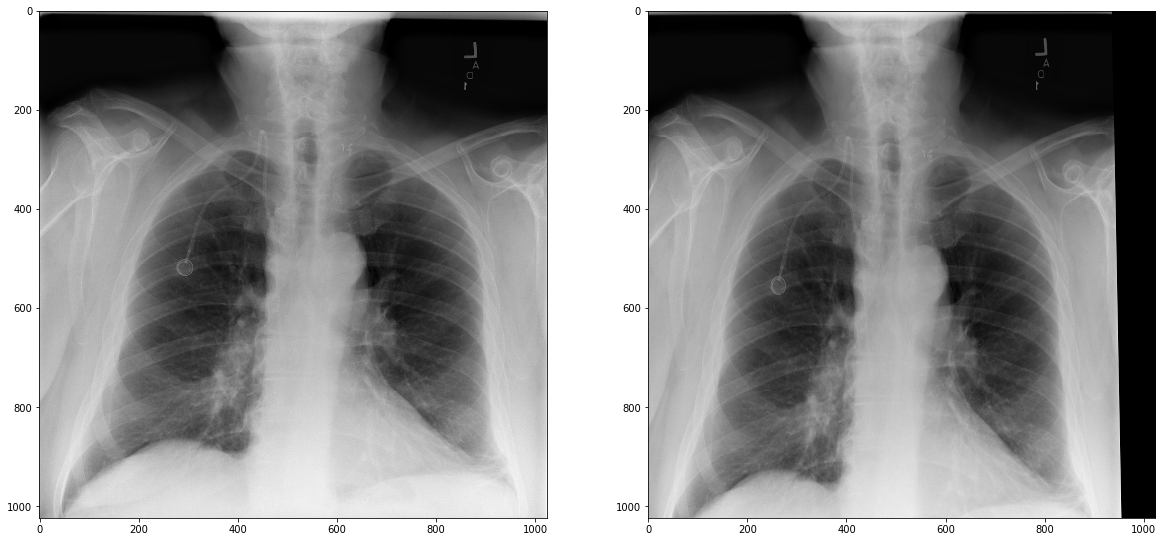

In [33]:
from transform import *
from image import (
    TransformParameters,
    adjust_transform_for_image,
    apply_transform,
    preprocess_image,
    resize_image
)
import numpy as np
import math
import skimage.io
import skimage.transform
import skimage.color
import skimage

from PIL import Image
import os
import random 
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
import cv2
from matplotlib.patches import Rectangle
DATA_DIR = "/data/krf/dataset/stage_1_test_images"
filepath = "/data/krf/dataset/stage_1_test_labels.csv"
images = os.listdir(DATA_DIR)
print(len(images))
img_name = random.choice(images)
print(img_name)
ds = pydicom.read_file(DATA_DIR+"/"+img_name)

df = pd.read_csv(filepath)
patientId = os.path.splitext(img_name)[0]
results = df[df["patientId"]==patientId].values
boxes_true = np.array([])
if results[0][5] == 1:
    boxes_true = results[:,1:5]
    #print(boxes_true)
    boxes_true = np.array(boxes_true)
    boxes_true = boxes_true.astype(np.int)
im_array = ds.pixel_array

fig, m_axs = plt.subplots(1, 2, figsize = (20, 20))
c_ax = m_axs.flatten()[0]
c_ax.imshow(im_array, cmap=plt.cm.gist_gray)
sample = {}
sample['img'] = skimage.color.gray2rgb(im_array)
# print(sample['img'])
annots = []
for j in range(len(boxes_true)):
    bbox = boxes_true[j]
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    w = int(bbox[2])
    h = int(bbox[3])
    x2 = x1+w
    y2 = y1+h
    #cv2.rectangle(image, (x1, y1), (x2, y2),(77, 255, 9),10)
    print("True:x {} y {} h {} w {}".format(x1, y1, w, h))
        
    annots.append([x1,y1,x2,y2])
    pch = c_ax.add_patch(Rectangle(xy=(x1,y1),width=w,height=h,alpha=0.5,fill=False))
    pch.set_edgecolor('r')
    pch.set_linewidth(3)
if len(annots) == 0:
    annots = [[0,0,0,0]]
sample['annot'] = np.asarray(annots)
image = sample['img']
annots = np.asarray(annots)
trs = random_transform(
            min_rotation=-0.05,
            max_rotation=0.05,
            min_translation=(-0.1, -0.1),
            max_translation=(0.1, 0.1),
#             min_shear=-0.5,
#             max_shear=0.5,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            #flip_y_chance=0.5,
        )
tr = adjust_transform_for_image(trs, image, True)
image     = apply_transform(tr, image,None)#TransformParameters())

# Transform the bounding boxes in the annotations.
annotations = annots.copy()
if not (annotations[0,2] == 0 or annotations[0,3] == 0):
    for index in range(annotations.shape[0]):
        annotations[index, :4] = transform_aabb(tr, annotations[index, :4])
boxes_true = annotations
# tr = adjust_transform_for_image(tr, sample['img'], True)
# im2 = cv2.warpAffine(sample['img'],
#                      tr[:2, :],
#                     dsize       = (1024, 1024),)
#sample_ = process(sample,flip_x = 0,shift = 1)
# print(sample['img']
# boxes_true = []
# for annot in annots:
#     boxes_true.append(transform_aabb(tr,annot))

#im2 = sample_['img']
#boxes_true = sample['annot']
print(boxes_true)
# print(im2[:,:,0])            

#im2=move(im_array)
#im2 = XRotate(im_array)
#im2 = scale(im_array)
#im2 = noise(im_array)
# im2 = hist_equ(im_array,mode='gray')
c_ax = m_axs.flatten()[1]
c_ax.imshow(image,cmap=plt.cm.gist_gray)
for j in range(len(boxes_true)):
    bbox = boxes_true[j]
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    w = x2 - x1
    h = y2 - y1
    #cv2.rectangle(image, (x1, y1), (x2, y2),(77, 255, 9),10)
    print("True:x {} y {} h {} w {}".format(x1, y1, w, h))
    pch = c_ax.add_patch(Rectangle(xy=(x1,y1),width=w,height=h,alpha=0.5,fill=False))
    pch.set_edgecolor('r')
    pch.set_linewidth(3)

In [36]:

image = np.asarray(image)
print(image.shape)
image = image[:,:, ::-1]
print(image)

(3, 2, 5)
[[[5 4 3 2 1]
  [5 4 3 2 1]]

 [[5 4 3 2 2]
  [5 4 3 2 2]]

 [[5 4 3 2 3]
  [5 4 3 2 3]]]


Using TensorFlow backend.
